In [1]:
#DSC540 Final Project
'''created by Kyle Spanski with sections of code from Casey Bennett'''

import sys
import csv
import math
import numpy as np
from operator import itemgetter
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import chdir
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.tree import  DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.externals import joblib
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, scale
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#Handle annoying warnings
import warnings, sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)


#############################################################################
#
# Global parameters
#
#####################
                                                                                                                                            
                                                                                  
fs_type=2                                           #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection)                        
feat_start=0                                        #Start column of features

#Set global model parameters
rand_st=1                                           #Set Random State variable for randomizing splits on runs


#############################################################################
#
# Load Data
#
#####################

data = pd.read_csv("drug_consumption.data.txt", index_col=0, na_values=["?"])


In [2]:
#View the data
data.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
ID,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [3]:
#Converting all to objects so we can better create dummies / medians
data[["Age", "Gender", "Education", "Country", "Ethnicity"]] = data[["Age", "Gender", "Education", "Country", "Ethnicity"]].astype(str) 

In [4]:
#Find unique ages
data.Age.unique()

array(['0.49788000000000004', '-0.07854', '-0.9519700000000001',
       '2.59171', '1.09449', '1.82213'], dtype=object)

In [5]:
#Using median of age values (and 70 for 65+ group)
def label_age (row):
    if row == "-0.9519700000000001":
        return 21
    if row == "-0.07854":
        return 29.5
    if row == "0.49788000000000004":
        return 39.5
    if row == "1.09449":
        return 49.5
    if row == "1.82213":
        return 59.5
    if row == "2.59171":
        return 70
    return "Other"

data['Age'] = data["Age"].apply (lambda row: label_age (row))

In [6]:
#Find unique genders
data.Gender.unique()

array(['0.48246000000000006', '-0.48246000000000006'], dtype=object)

In [7]:
#Updating gender from numerical values to string objects (will make dummies later)
def label_gender (row):
    if row == "0.48246000000000006":
        return "Female"
    if row == "-0.48246000000000006":
        return "Male"
    return "Other"

data['Gender'] = data["Gender"].apply (lambda row: label_gender (row))

In [8]:
#Find unique education values
data.Education.unique()

array(['-0.059210000000000006', '1.98437', '1.16365', '-1.22751',
       '-1.7379', '0.45468000000000003', '-0.6111300000000001',
       '-2.43591', '-1.43719'], dtype=object)

In [9]:
#Updating to actual education years
def label_education (row):
    if row == "-2.43591":
        return 14
    if row == "-1.7379":
        return 16
    if row == "-1.43719":
        return 17
    if row == "-1.22751":
        return 18
    if row == "-0.6111300000000001":
        return 20
    if row == "-0.059210000000000006":
        return 21
    if row == "0.45468000000000003":
        return 22
    if row == "1.16365":
        return 24
    if row == "1.98437":
        return 26
    return "Other"

data['Education'] = data["Education"].apply (lambda row: label_education (row))

In [10]:
#Find unique countries
data.Country.unique()

array(['0.9608200000000001', '0.24923', '-0.57009', '-0.28519',
       '-0.09765', '0.21128000000000002', '-0.46841000000000005'],
      dtype=object)

In [11]:
#Updating to actual countries
def label_country (row):
    if row == "-0.09765":
        return "Australia"
    if row == "0.24923":
        return "Canada"
    if row == "-0.46841000000000005":
        return "New Zealand"
    if row == "-0.28519":
        return "Other_Country"
    if row == "0.21128000000000002":
        return "Ireland"
    if row == "0.9608200000000001":
        return "UK"
    if row == "-0.57009":
        return "USA"
    return "Other"

data['Country'] = data["Country"].apply (lambda row: label_country (row))

In [12]:
#Find unique ethnicities
data.Ethnicity.unique()

array(['0.126', '-0.31685', '0.1144', '-0.22166', '-0.50212',
       '-1.1070200000000001', '1.90725'], dtype=object)

In [13]:
#Updating to actual ethnicities
def label_ethnicity (row):
    if row == "0.126":
        return "White/Asian"
    if row == "-0.31685":
        return "White"
    if row == "0.1144":
        return "Other_Ethnicity"
    if row == "-0.22166":
        return "White/Black"
    if row == "-0.50212":
        return "Asian"
    if row == "-1.1070200000000001":
        return "Black"
    if row == "1.90725":
        return "Black/Asian"
    return "Other"

data['Ethnicity'] = data["Ethnicity"].apply (lambda row: label_ethnicity (row))

In [14]:
#Describe features
data.describe()

,Age,Education,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,33.475332,21.083289,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,12.258108,2.413242,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,21.000000,14.000000,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,21.000000,20.000000,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,29.500000,21.000000,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,39.500000,22.000000,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,70.000000,26.000000,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [15]:
data = data[data.Semer == 'CL0']
data.describe()

,Age,Education,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
count,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000
mean,33.514118,21.090570,-0.000551,-0.001951,-0.003224,-0.000657,-0.000394,0.005293,-0.007408
std,12.262746,2.412057,0.998442,0.997418,0.995691,0.996689,0.997657,0.954148,0.962074
min,21.000000,14.000000,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,21.000000,20.000000,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,29.500000,21.000000,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,39.500000,22.000000,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,70.000000,26.000000,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [16]:
#Splitting out target variables
targets = pd.concat([data.pop(x) for x in ['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy',
                                          'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']], 1)

In [17]:
#Makeing features into dummies for Gender, Age Group, Ethnicity, Country and Education
data_dummies = pd.get_dummies(data)

In [18]:
#Drop fake Semer drug
targets = targets.drop(['Semer'], axis=1)

In [19]:
#Changing classess in targets to actual numbers
d = {'CL0':0,'CL1':1,'CL2':2,'CL3':3,'CL4':4,'CL5':5,'CL6':6}
targets = targets.replace(d)

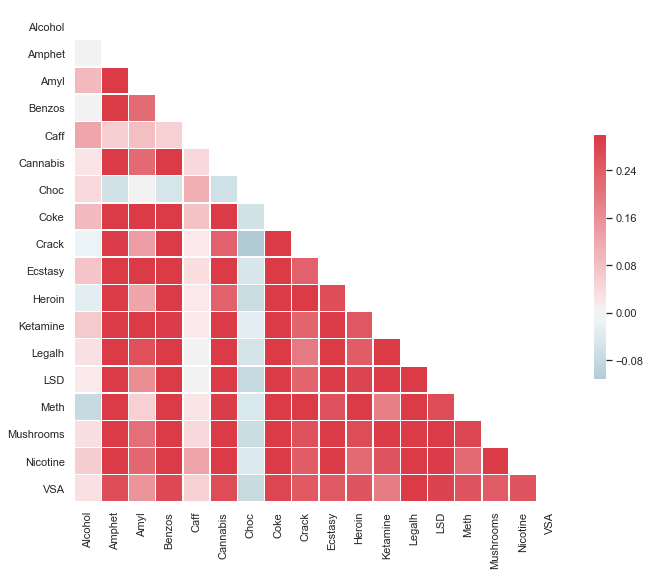

In [20]:
#Showing correlation between target variables

sns.set(style="white")

# Compute the correlation matrix
corr = targets.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

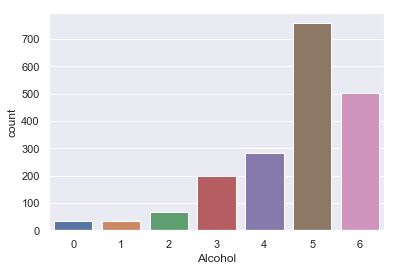

In [21]:
#Histograms of classes for numeric target variables

sns.set(style="darkgrid")

ax = sns.countplot(x='Alcohol', data=targets)

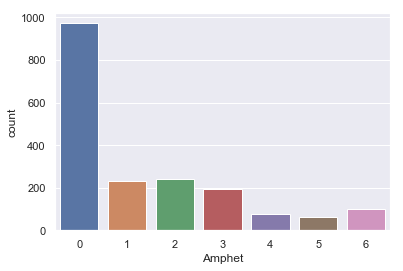

In [22]:
ax = sns.countplot(x='Amphet', data=targets)

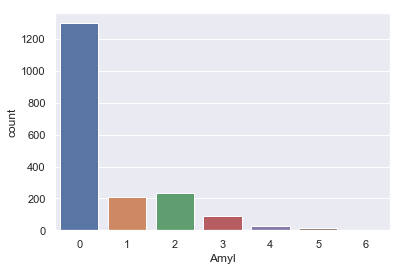

In [23]:
ax = sns.countplot(x='Amyl', data=targets)

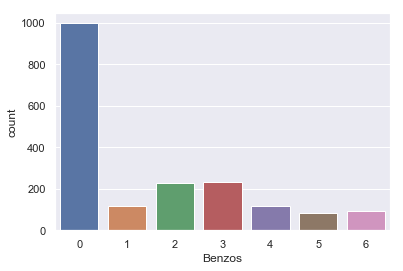

In [24]:
ax = sns.countplot(x='Benzos', data=targets)

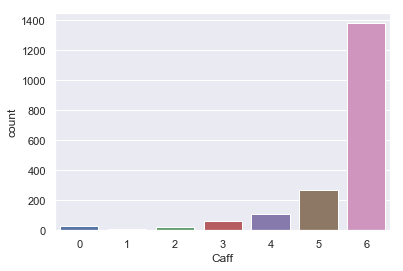

In [25]:
ax = sns.countplot(x='Caff', data=targets)

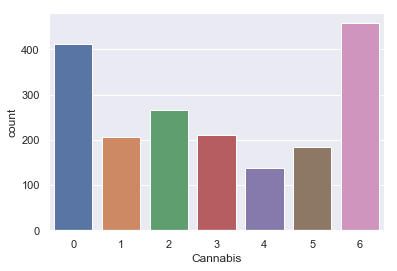

In [26]:
ax = sns.countplot(x='Cannabis', data=targets)

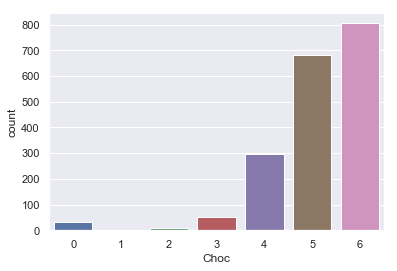

In [27]:
ax = sns.countplot(x='Choc', data=targets)

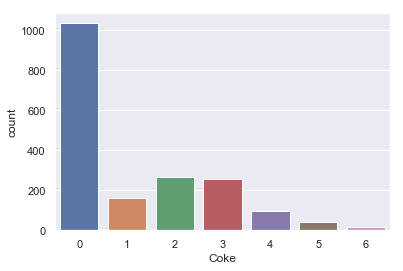

In [28]:
ax = sns.countplot(x='Coke', data=targets)

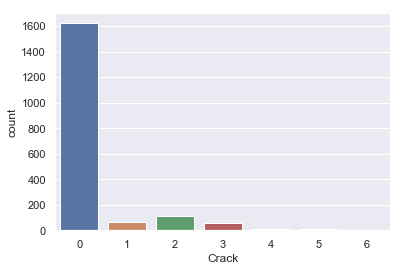

In [29]:
ax = sns.countplot(x='Crack', data=targets)

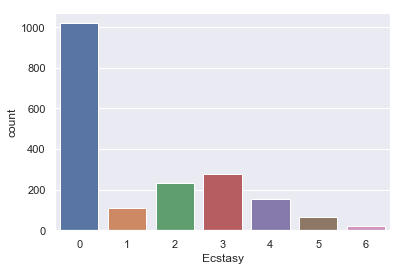

In [30]:
ax = sns.countplot(x='Ecstasy', data=targets)

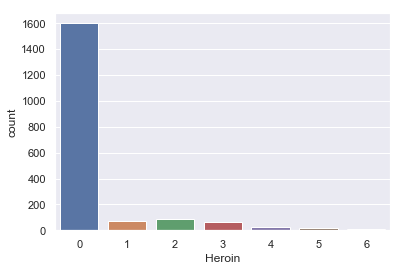

In [31]:
ax = sns.countplot(x='Heroin', data=targets)

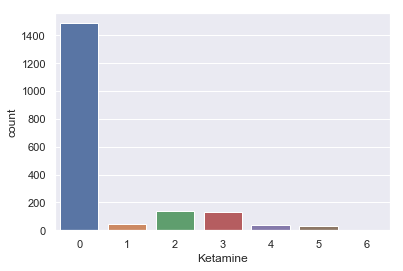

In [32]:
ax = sns.countplot(x='Ketamine', data=targets)

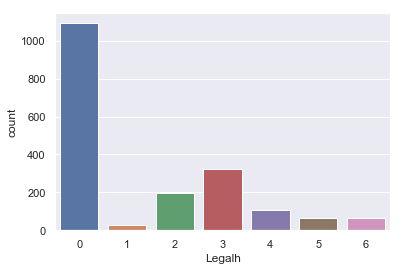

In [33]:
ax = sns.countplot(x='Legalh', data=targets)

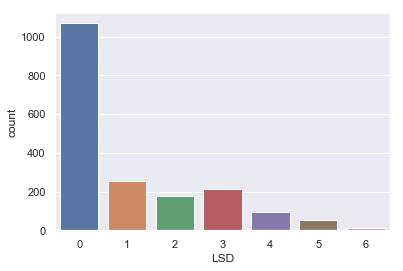

In [34]:
ax = sns.countplot(x='LSD', data=targets)

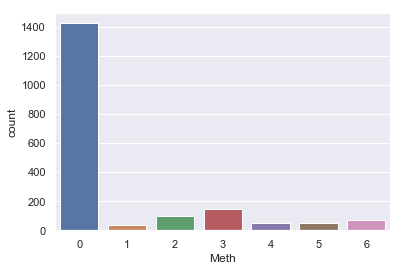

In [35]:
ax = sns.countplot(x='Meth', data=targets)

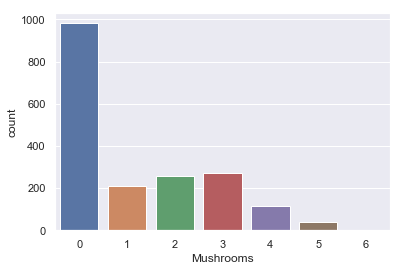

In [36]:
ax = sns.countplot(x='Mushrooms', data=targets)

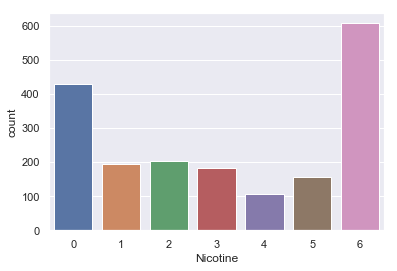

In [37]:
ax = sns.countplot(x='Nicotine', data=targets)

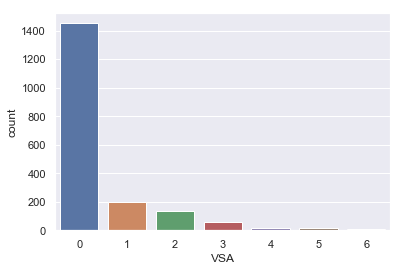

In [38]:
ax = sns.countplot(x='VSA', data=targets)

In [39]:
#Adding constant for VIF calculation
X = add_constant(data_dummies)
#VIF Calculation
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

C:\Users\kspansk1\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\kspansk1\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                        0.000000
Age                          1.232605
Education                    1.137864
Nscore                       1.501887
Escore                       1.581143
Oscore                       1.441889
Ascore                       1.205285
Cscore                       1.479593
Impulsive                    1.814048
SS                           2.105431
Gender_Female                     inf
Gender_Male                       inf
Country_Australia                 inf
Country_Canada                    inf
Country_Ireland                   inf
Country_New Zealand               inf
Country_Other_Country             inf
Country_UK                        inf
Country_USA                       inf
Ethnicity_Asian                   inf
Ethnicity_Black                   inf
Ethnicity_Black/Asian             inf
Ethnicity_Other_Ethnicity         inf
Ethnicity_White                   inf
Ethnicity_White/Asian             inf
Ethnicity_White/Black             inf
dtype: float

In [40]:
#Dropping one category for eacch dummy variable so VIF is better
data_dummies = pd.get_dummies(data, drop_first=True)
Y = add_constant(data_dummies)
pd.Series([variance_inflation_factor(Y.values, i) 
               for i in range(Y.shape[1])], 
              index=Y.columns)

const                        218.681726
Age                            1.232605
Education                      1.137864
Nscore                         1.501887
Escore                         1.581143
Oscore                         1.441889
Ascore                         1.205285
Cscore                         1.479593
Impulsive                      1.814048
SS                             2.105431
Gender_Male                    1.214288
Country_Canada                 2.579212
Country_Ireland                1.376018
Country_New Zealand            1.096718
Country_Other_Country          3.105130
Country_UK                     9.624785
Country_USA                    8.301681
Ethnicity_Black                2.291192
Ethnicity_Black/Asian          1.127497
Ethnicity_Other_Ethnicity      3.431968
Ethnicity_White                6.082627
Ethnicity_White/Asian          1.797032
Ethnicity_White/Black          1.751068
dtype: float64

In [41]:
#We dropped Gender_Female, Country_Australia, Ethnicity_Asian and the VIF is much lower

In [42]:
#Updating targets to binary values (user of drug or not a user of drug)
d = {0:0,1:1,2:1,3:1,4:1,5:1,6:1}
Targets_Binary = targets.replace(d)

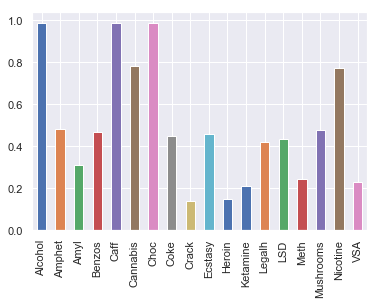

In [43]:
#Find mean of Binary Targets (percent of respondents who ever used drug)
Targets_Binary.mean().plot(kind='bar')

In [51]:
means = Targets_Binary.mean()
means.sort_values(ascending=False)

Caff         0.985615
Choc         0.982952
Alcohol      0.982419
Cannabis     0.779968
Nicotine     0.771977
Amphet       0.481620
Mushrooms    0.476825
Benzos       0.467768
Ecstasy      0.456580
Coke         0.448055
LSD          0.430474
Legalh       0.418221
Amyl         0.307938
Meth         0.241343
VSA          0.226425
Ketamine     0.207246
Heroin       0.147576
Crack        0.135855
dtype: float64

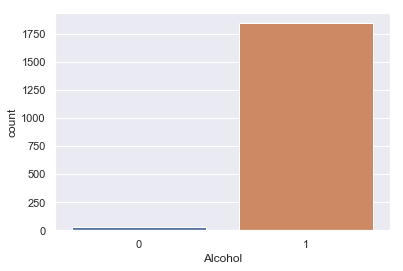

In [52]:
ax = sns.countplot(x='Alcohol', data=Targets_Binary)

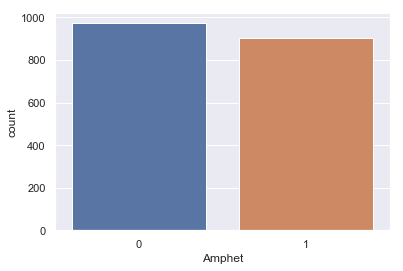

In [53]:
ax = sns.countplot(x='Amphet', data=Targets_Binary)

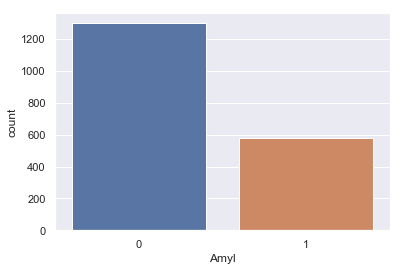

In [54]:
ax = sns.countplot(x='Amyl', data=Targets_Binary)

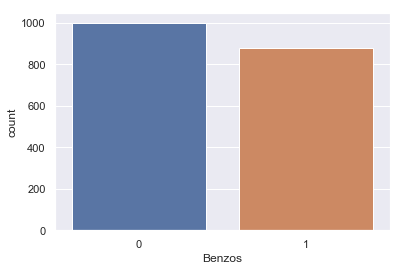

In [55]:
ax = sns.countplot(x='Benzos', data=Targets_Binary)

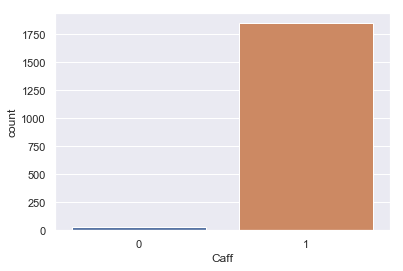

In [56]:
ax = sns.countplot(x='Caff', data=Targets_Binary)

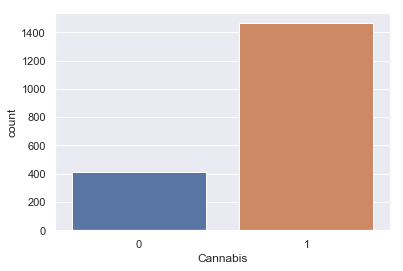

In [57]:
ax = sns.countplot(x='Cannabis', data=Targets_Binary)

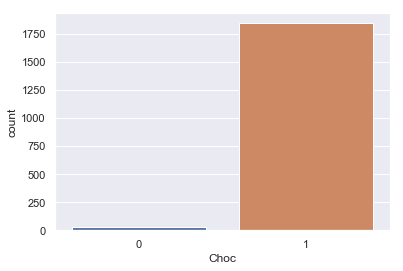

In [58]:
ax = sns.countplot(x='Choc', data=Targets_Binary)

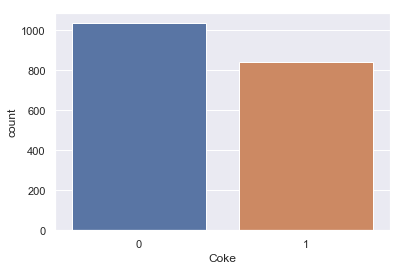

In [59]:
ax = sns.countplot(x='Coke', data=Targets_Binary)

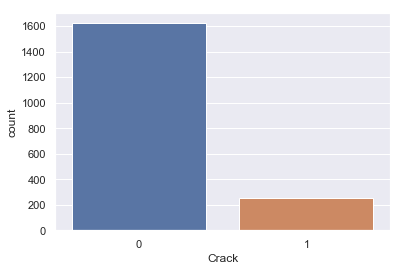

In [60]:
ax = sns.countplot(x='Crack', data=Targets_Binary)

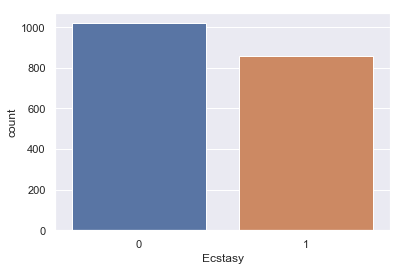

In [61]:
ax = sns.countplot(x='Ecstasy', data=Targets_Binary)

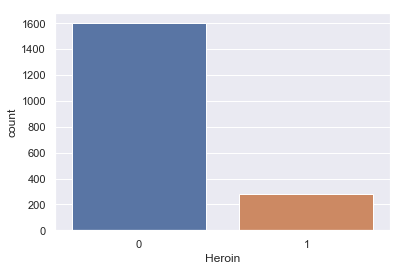

In [62]:
ax = sns.countplot(x='Heroin', data=Targets_Binary)

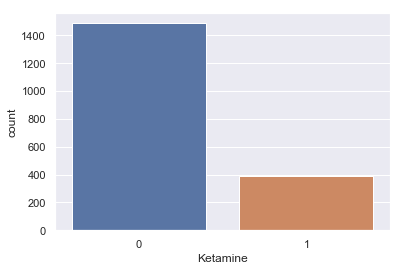

In [63]:
ax = sns.countplot(x='Ketamine', data=Targets_Binary)

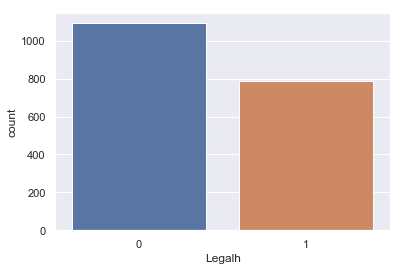

In [64]:
ax = sns.countplot(x='Legalh', data=Targets_Binary)

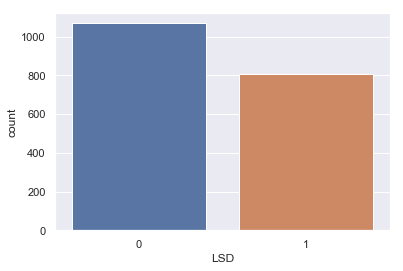

In [65]:
ax = sns.countplot(x='LSD', data=Targets_Binary)

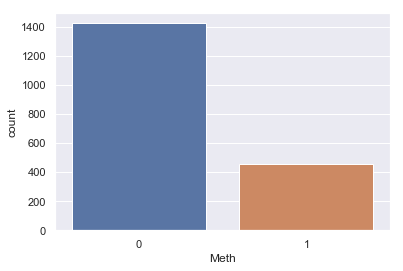

In [66]:
ax = sns.countplot(x='Meth', data=Targets_Binary)

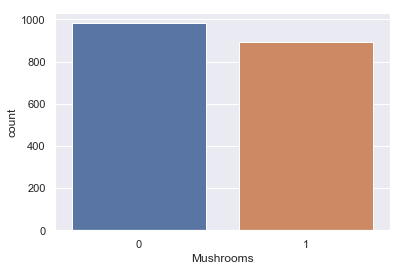

In [67]:
ax = sns.countplot(x='Mushrooms', data=Targets_Binary)

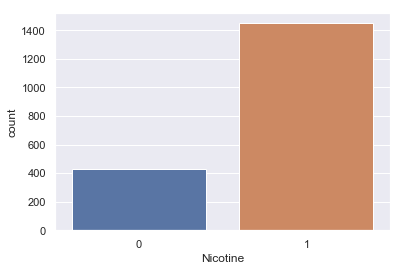

In [68]:
ax = sns.countplot(x='Nicotine', data=Targets_Binary)

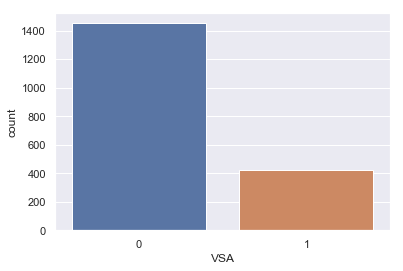

In [69]:
ax = sns.countplot(x='VSA', data=Targets_Binary)

In [70]:
#Trying Deision Trees with regular training / test split (80/20) for Binary Variable and no FS

for drug in list(Targets_Binary):
    data_np=np.asarray(data_dummies)
    target_np=np.asarray(Targets_Binary[drug])

    #Test/Train split
    data_train, data_test, target_train, target_test = train_test_split(data_dummies, Targets_Binary[drug], test_size=0.2)

    ####Classifiers####
        
    #SciKit Decision Tree
    clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=rand_st)
    clf.fit(data_train, target_train)

    scores_ACC = clf.score(data_test, target_test)
    print (drug)
    print('Decision Tree Acc:', scores_ACC)
    scores_AUC = metrics.roc_auc_score(target_test, clf.predict_proba(data_test)[:,1])
    print('Decision Tree AUC:', scores_AUC)                                                                     #AUC only works with binary classes, not multiclass            



Alcohol
Decision Tree Acc: 0.9787234042553191
Decision Tree AUC: 0.4946236559139785
Amphet
Decision Tree Acc: 0.6542553191489362
Decision Tree AUC: 0.6585727314181486
Amyl
Decision Tree Acc: 0.6409574468085106
Decision Tree AUC: 0.5411465557096625
Benzos
Decision Tree Acc: 0.6090425531914894
Decision Tree AUC: 0.6080039665675024
Caff
Decision Tree Acc: 0.9601063829787234
Decision Tree AUC: 0.4865229110512129
Cannabis
Decision Tree Acc: 0.7686170212765957
Decision Tree AUC: 0.6694630872483222
Choc
Decision Tree Acc: 0.9388297872340425
Decision Tree AUC: 0.4757412398921833
Coke
Decision Tree Acc: 0.5851063829787234
Decision Tree AUC: 0.5761904761904763
Crack
Decision Tree Acc: 0.7925531914893617
Decision Tree AUC: 0.5510828184484803
Ecstasy
Decision Tree Acc: 0.6436170212765957
Decision Tree AUC: 0.6351678781585323
Heroin
Decision Tree Acc: 0.7526595744680851
Decision Tree AUC: 0.5444371115877468
Ketamine
Decision Tree Acc: 0.7313829787234043
Decision Tree AUC: 0.5860526315789474
Legalh


In [71]:
#Decision Trees for Binary Target with CV and no FS
for drug in list(Targets_Binary):
    data_np=np.asarray(data_dummies)
    target_np=np.asarray(Targets_Binary[drug])
#Setup Crossval classifier scorers
    scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

    #SciKit Decision Tree - Cross Val
    start_ts=time.time()
    clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=rand_st)

    scores = cross_validate(clf, data_np,Targets_Binary[drug] , scoring=scorers, cv=5)

    scores_Acc = scores['test_Accuracy']
    print (drug)
    print("Decision Tree Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
    scores_AUC= scores['test_roc_auc']                                                                      #Only works with binary classes, not multiclass
    print("Decision Tree AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
    print("CV Runtime:", time.time()-start_ts)
    print('\n')

Alcohol
Decision Tree Acc: 0.96 (+/- 0.03)
Decision Tree AUC: 0.49 (+/- 0.01)
CV Runtime: 0.030079126358032227


Amphet
Decision Tree Acc: 0.60 (+/- 0.05)
Decision Tree AUC: 0.60 (+/- 0.05)
CV Runtime: 0.03910970687866211


Amyl
Decision Tree Acc: 0.63 (+/- 0.02)
Decision Tree AUC: 0.58 (+/- 0.04)
CV Runtime: 0.03233075141906738


Benzos
Decision Tree Acc: 0.59 (+/- 0.03)
Decision Tree AUC: 0.59 (+/- 0.02)
CV Runtime: 0.041855573654174805


Caff
Decision Tree Acc: 0.96 (+/- 0.03)
Decision Tree AUC: 0.51 (+/- 0.08)
CV Runtime: 0.02309131622314453


Cannabis
Decision Tree Acc: 0.74 (+/- 0.11)
Decision Tree AUC: 0.62 (+/- 0.06)
CV Runtime: 0.03575634956359863


Choc
Decision Tree Acc: 0.96 (+/- 0.02)
Decision Tree AUC: 0.50 (+/- 0.06)
CV Runtime: 0.031054019927978516


Coke
Decision Tree Acc: 0.62 (+/- 0.03)
Decision Tree AUC: 0.61 (+/- 0.03)
CV Runtime: 0.03810477256774902


Crack
Decision Tree Acc: 0.79 (+/- 0.06)
Decision Tree AUC: 0.56 (+/- 0.06)
CV Runtime: 0.03709912300109863


Ecst

In [72]:
#Decision Tree with CV and Feature Selection
for drug in list(Targets_Binary):
    data_np=np.asarray(data_dummies)
    target_np=np.asarray(Targets_Binary[drug])
    
    header=[]
   
    '''Three steps:
       1) Run Feature Selection
       2) Get lists of selected and non-selected features
       3) Filter columns from original dataset
       '''

    print('--FEATURE SELECTION ON--', '\n')

    ##1) Run Feature Selection #######
    #Wrapper Select via model



    if fs_type==2:
        clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=rand_st) 
        sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                   
        print (drug)

        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()


##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(i+feat_start)
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Wrapper Select:', data_dummies.columns.values[temp])
    print('Features (total/selected):', len(data_np[0]), len(temp))
    print('\n')


##3) Filter selected columns from original dataset #########
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index)
    ####Cross-Val Classifiers####

    #Setup Crossval classifier scorers
    scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

    #SciKit Decision Tree - Cross Val
    start_ts=time.time()
    clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=rand_st)
    clf = clf.fit(data_np, Targets_Binary[drug])
    scores = cross_validate(clf, data_np,Targets_Binary[drug] , scoring=scorers, cv=5)

    scores_Acc = scores['test_Accuracy']
    print("Decision Tree Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
    scores_AUC= scores['test_roc_auc']                                                                      #Only works with binary classes, not multiclass
    print("Decision Tree AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
    print("CV Runtime:", time.time()-start_ts)
    print('\n')  
                

--FEATURE SELECTION ON-- 

Alcohol
Wrapper Select: ['Age' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore' 'SS' 'Country_UK']
Features (total/selected): 22 8


Decision Tree Acc: 0.95 (+/- 0.03)
Decision Tree AUC: 0.48 (+/- 0.01)
CV Runtime: 0.02762746810913086


--FEATURE SELECTION ON-- 

Amphet
Wrapper Select: ['Age' 'Education' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore'
 'Impulsive' 'SS' 'Country_UK']
Features (total/selected): 22 10


Decision Tree Acc: 0.58 (+/- 0.05)
Decision Tree AUC: 0.58 (+/- 0.04)
CV Runtime: 0.028237104415893555


--FEATURE SELECTION ON-- 

Amyl
Wrapper Select: ['Age' 'Education' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore'
 'Impulsive' 'SS' 'Country_USA']
Features (total/selected): 22 10


Decision Tree Acc: 0.63 (+/- 0.03)
Decision Tree AUC: 0.57 (+/- 0.04)
CV Runtime: 0.03429698944091797


--FEATURE SELECTION ON-- 

Benzos
Wrapper Select: ['Education' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore' 'Impulsive' 'SS'
 'Country_UK']
Features (total/selected): 22 

--FEATURE SELECTION ON-- 

Alcohol
Wrapper Select: ['Ascore' 'Country_UK' 'Ethnicity_White']
Features (total/selected): 22 3


Decision Tree Acc: 0.98 (+/- 0.00)
Decision Tree AUC: 0.69 (+/- 0.18)
CV Runtime: 0.015039682388305664




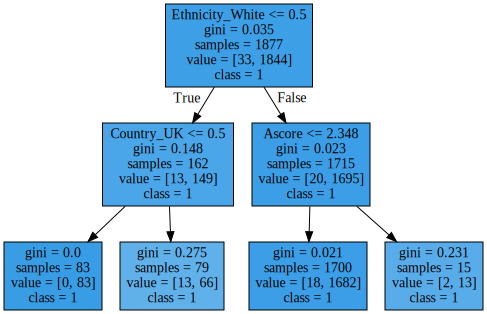

--FEATURE SELECTION ON-- 

Amphet
Wrapper Select: ['SS' 'Country_UK']
Features (total/selected): 22 2


Decision Tree Acc: 0.63 (+/- 0.12)
Decision Tree AUC: 0.70 (+/- 0.11)
CV Runtime: 0.015067100524902344




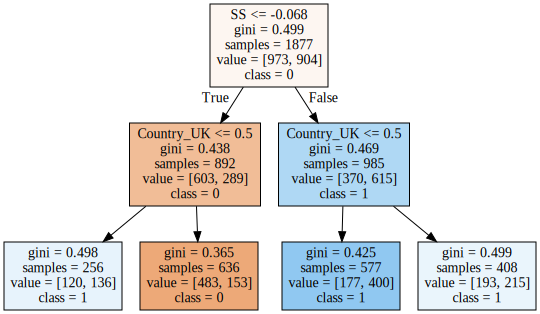

--FEATURE SELECTION ON-- 

Amyl
Wrapper Select: ['SS' 'Gender_Male' 'Country_USA']
Features (total/selected): 22 3


Decision Tree Acc: 0.68 (+/- 0.04)
Decision Tree AUC: 0.65 (+/- 0.12)
CV Runtime: 0.015039920806884766




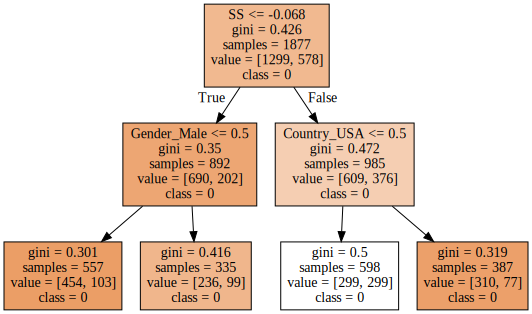

--FEATURE SELECTION ON-- 

Benzos
Wrapper Select: ['Nscore' 'Cscore' 'Country_UK']
Features (total/selected): 22 3


Decision Tree Acc: 0.66 (+/- 0.12)
Decision Tree AUC: 0.69 (+/- 0.11)
CV Runtime: 0.014571189880371094




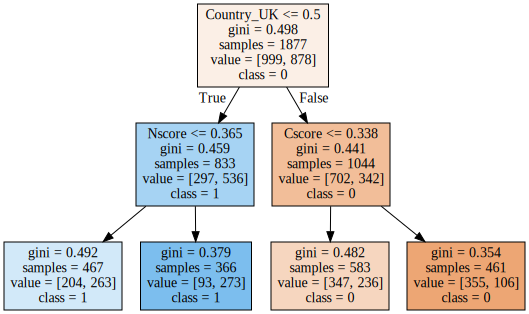

--FEATURE SELECTION ON-- 

Caff
Wrapper Select: ['Nscore' 'Country_UK' 'Ethnicity_Black']
Features (total/selected): 22 3


Decision Tree Acc: 0.98 (+/- 0.00)
Decision Tree AUC: 0.74 (+/- 0.21)
CV Runtime: 0.014007091522216797




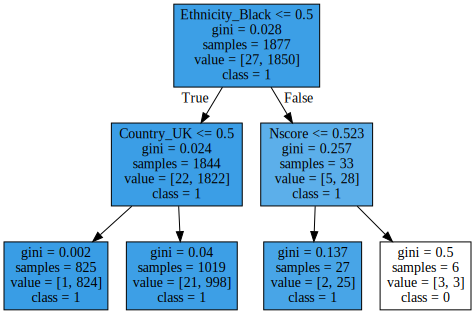

--FEATURE SELECTION ON-- 

Cannabis
Wrapper Select: ['SS' 'Country_UK']
Features (total/selected): 22 2


Decision Tree Acc: 0.73 (+/- 0.17)
Decision Tree AUC: 0.78 (+/- 0.19)
CV Runtime: 0.014037370681762695




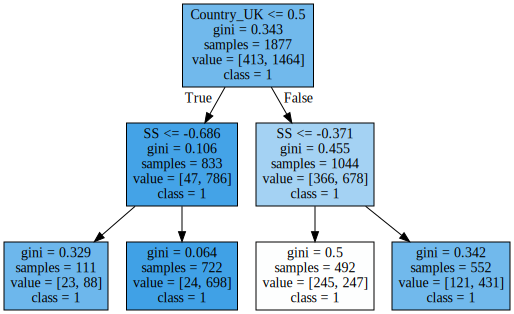

--FEATURE SELECTION ON-- 

Choc
Wrapper Select: ['Cscore' 'Ethnicity_Black']
Features (total/selected): 22 2


Decision Tree Acc: 0.98 (+/- 0.00)
Decision Tree AUC: 0.52 (+/- 0.10)
CV Runtime: 0.01300668716430664




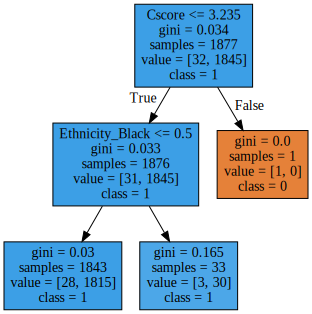

--FEATURE SELECTION ON-- 

Coke
Wrapper Select: ['SS' 'Country_USA']
Features (total/selected): 22 2


Decision Tree Acc: 0.65 (+/- 0.10)
Decision Tree AUC: 0.69 (+/- 0.08)
CV Runtime: 0.015576839447021484




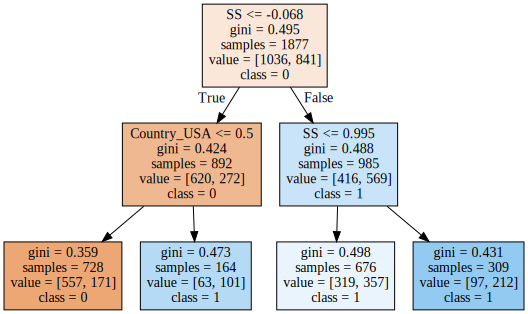

--FEATURE SELECTION ON-- 

Crack
Wrapper Select: ['Age' 'Impulsive' 'Country_UK']
Features (total/selected): 22 3


Decision Tree Acc: 0.86 (+/- 0.00)
Decision Tree AUC: 0.72 (+/- 0.13)
CV Runtime: 0.01399540901184082




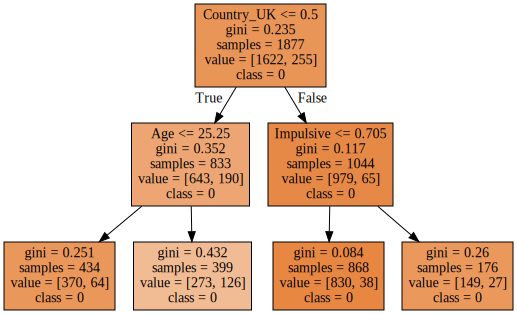

--FEATURE SELECTION ON-- 

Ecstasy
Wrapper Select: ['Age' 'SS' 'Country_USA']
Features (total/selected): 22 3


Decision Tree Acc: 0.69 (+/- 0.09)
Decision Tree AUC: 0.71 (+/- 0.09)
CV Runtime: 0.015068769454956055




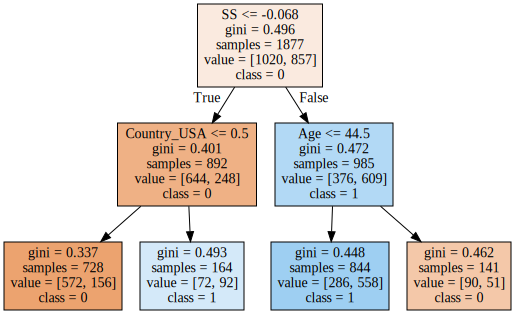

--FEATURE SELECTION ON-- 

Heroin
Wrapper Select: ['Nscore' 'SS' 'Country_USA']
Features (total/selected): 22 3


Decision Tree Acc: 0.85 (+/- 0.00)
Decision Tree AUC: 0.73 (+/- 0.06)
CV Runtime: 0.014542341232299805




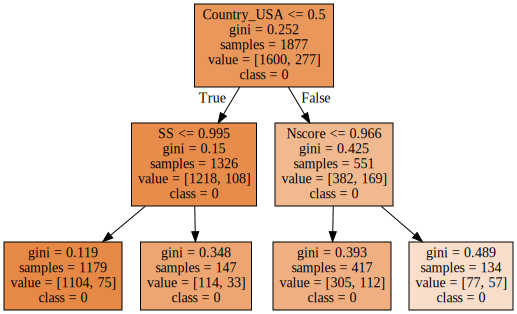

--FEATURE SELECTION ON-- 

Ketamine
Wrapper Select: ['Ascore' 'Cscore' 'SS']
Features (total/selected): 22 3


Decision Tree Acc: 0.79 (+/- 0.01)
Decision Tree AUC: 0.67 (+/- 0.10)
CV Runtime: 0.016051769256591797




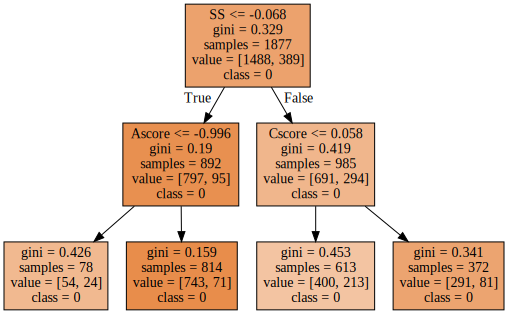

--FEATURE SELECTION ON-- 

Legalh
Wrapper Select: ['Age' 'SS' 'Gender_Male']
Features (total/selected): 22 3


Decision Tree Acc: 0.71 (+/- 0.08)
Decision Tree AUC: 0.79 (+/- 0.10)
CV Runtime: 0.014038562774658203




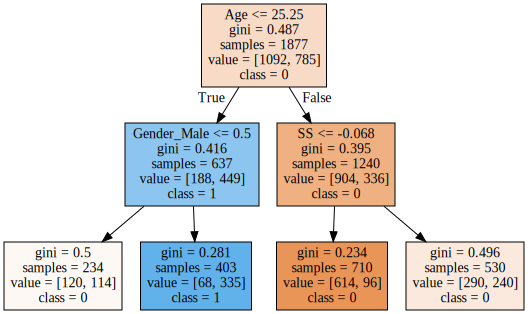

--FEATURE SELECTION ON-- 

LSD
Wrapper Select: ['Oscore' 'SS' 'Country_UK']
Features (total/selected): 22 3


Decision Tree Acc: 0.73 (+/- 0.12)
Decision Tree AUC: 0.77 (+/- 0.14)
CV Runtime: 0.014595270156860352




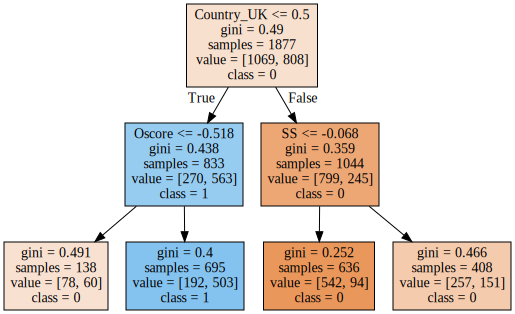

--FEATURE SELECTION ON-- 

Meth
Wrapper Select: ['Cscore' 'Country_UK' 'Country_USA']
Features (total/selected): 22 3


Decision Tree Acc: 0.78 (+/- 0.10)
Decision Tree AUC: 0.76 (+/- 0.16)
CV Runtime: 0.014036893844604492




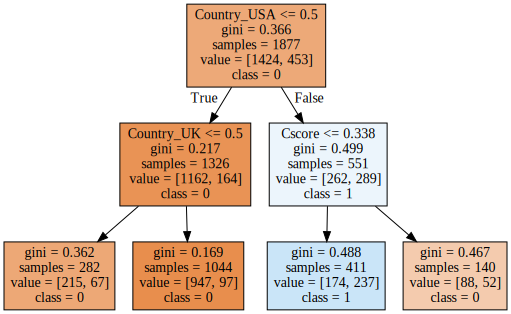

--FEATURE SELECTION ON-- 

Mushrooms
Wrapper Select: ['SS' 'Country_UK']
Features (total/selected): 22 2


Decision Tree Acc: 0.71 (+/- 0.12)
Decision Tree AUC: 0.75 (+/- 0.12)
CV Runtime: 0.01303243637084961




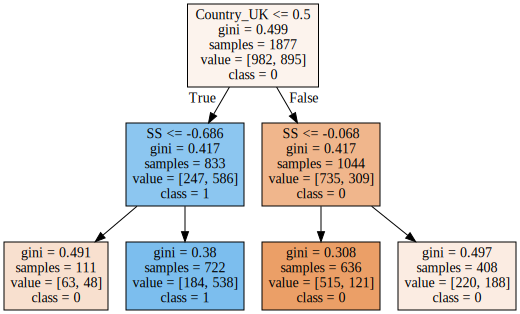

--FEATURE SELECTION ON-- 

Nicotine
Wrapper Select: ['Education' 'SS' 'Country_UK']
Features (total/selected): 22 3


Decision Tree Acc: 0.77 (+/- 0.00)
Decision Tree AUC: 0.66 (+/- 0.07)
CV Runtime: 0.015015363693237305




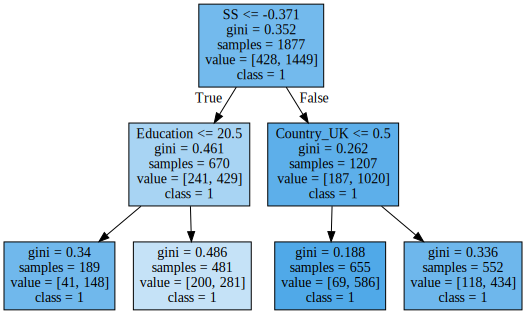

--FEATURE SELECTION ON-- 

VSA
Wrapper Select: ['SS' 'Country_UK']
Features (total/selected): 22 2


Decision Tree Acc: 0.77 (+/- 0.00)
Decision Tree AUC: 0.69 (+/- 0.15)
CV Runtime: 0.015066146850585938




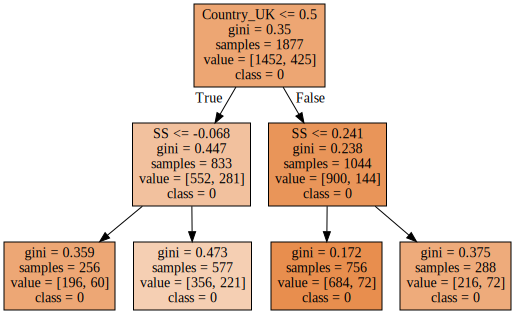

In [73]:
#Decision Tree with CV and Feature Selection and Depth = 2
for drug in list(Targets_Binary):
    data_np=np.asarray(data_dummies)
    target_np=np.asarray(Targets_Binary[drug])
    
    header=[]
   

    print('--FEATURE SELECTION ON--', '\n')

    ##1) Run Feature Selection #######
    #Wrapper Select via model



    if fs_type==2:
        #clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=rand_st) 

        clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=2, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=rand_st)
        sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                   
        print (drug)

        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()


##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(i+feat_start)
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Wrapper Select:', data_dummies.columns.values[temp])
    print('Features (total/selected):', len(data_np[0]), len(temp))
    print('\n')


##3) Filter selected columns from original dataset #########
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index)
    ####Cross-Val Classifiers####

    #Setup Crossval classifier scorers
    scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

    #SciKit Decision Tree - Cross Val
    start_ts=time.time()
    clf = clf.fit(data_np, Targets_Binary[drug])
    scores = cross_validate(clf, data_np,Targets_Binary[drug] , scoring=scorers, cv=5)

    scores_Acc = scores['test_Accuracy']
    print("Decision Tree Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
    scores_AUC= scores['test_roc_auc']                                                                      #Only works with binary classes, not multiclass
    print("Decision Tree AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
    print("CV Runtime:", time.time()-start_ts)
    print('\n')  
    graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=data_dummies.columns.values[temp], class_names=['0', '1', '2']  , filled = True))
    display(SVG(graph.pipe(format='svg')))

In [74]:
#Random Forest Classifier with Feature Selection and CV and Max Depth = 5
for drug in list(Targets_Binary):
    data_np=np.asarray(data_dummies)
    target_np=np.asarray(Targets_Binary[drug])
    header=[]
    #Feature Selection
    
    '''Three steps:
       1) Run Feature Selection
       2) Get lists of selected and non-selected features
       3) Filter columns from original dataset
       '''

    print('--FEATURE SELECTION ON--', '\n')
    print(Targets_Binary[drug].name)

    ##1) Run Feature Selection #######
    #Wrapper Select via model
    if fs_type==2:
        clf = RandomForestClassifier(n_estimators = 100, max_depth = 5, min_samples_split = 3, criterion = "entropy",
                                 random_state = rand_st)            
        sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                   

        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()


    ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(i+feat_start)
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Wrapper Select:', data_dummies.columns.values[temp])
    print('Features (total/selected):', len(data_np[0]), len(temp))


    ##3) Filter selected columns from original dataset #########
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index  

####Cross-Val Classifiers####

    #Setup Crossval classifier scorers
    scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}                                                                                                                

    #SciKit Random Forest - Cross Val
    start_ts=time.time()

    scores = cross_validate(clf, data_np, y = target_np, scoring = scorers, cv = 5)


    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
    scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
    print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
    print("CV Runtime:", time.time()-start_ts)


--FEATURE SELECTION ON-- 

Alcohol
Wrapper Select: ['Age' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore' 'Impulsive' 'SS'
 'Ethnicity_White']
Features (total/selected): 22 9
Random Forest Acc: 0.98 (+/- 0.00)
Random Forest AUC: 0.67 (+/- 0.22)
CV Runtime: 0.5568275451660156
--FEATURE SELECTION ON-- 

Amphet
Wrapper Select: ['Nscore' 'Oscore' 'Cscore' 'Impulsive' 'SS' 'Gender_Male' 'Country_UK'
 'Country_USA']
Features (total/selected): 22 8
Random Forest Acc: 0.68 (+/- 0.09)
Random Forest AUC: 0.74 (+/- 0.08)
CV Runtime: 0.5380737781524658
--FEATURE SELECTION ON-- 

Amyl
Wrapper Select: ['Age' 'Education' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore'
 'Impulsive' 'SS' 'Gender_Male' 'Country_UK' 'Country_USA']
Features (total/selected): 22 12
Random Forest Acc: 0.72 (+/- 0.02)
Random Forest AUC: 0.72 (+/- 0.08)
CV Runtime: 0.5991301536560059
--FEATURE SELECTION ON-- 

Benzos
Wrapper Select: ['Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore' 'Impulsive' 'SS'
 'Country_UK' 'Country_USA']
Features

In [75]:
#Let's test Random Forest Classifier and Feature Selection with Train / Test / Eval data (70/20/10)

#90/10 split
data_90, data_10, target_90, target_10 = train_test_split(data_dummies, Targets_Binary, test_size=0.1)

#80/20 Train / Test split on 90% of data 
data_train, data_test, target_train, target_test = train_test_split(data_90, target_90, test_size=0.2)

In [76]:
#Trying with Train / Test / Eval data sets (no feature selection)

for drug in list(target_90):
    data_np=np.asarray(data_90)
    target_np=np.asarray(target_90[drug])

          
    #SciKit Decision Tree
    clf = RandomForestClassifier(n_estimators = 100, max_depth = 5, min_samples_split = 3, criterion = "entropy",
                                     random_state = rand_st)             
    clf.fit(data_np, target_np)

    scores_ACC = clf.score(data_10, target_10[drug])
    print (drug)
    print('Decision Tree Acc:', scores_ACC)
    scores_AUC = metrics.roc_auc_score(target_10[drug], clf.predict_proba(data_10)[:,1])
    print('Decision Tree AUC:', scores_AUC)     

Alcohol
Decision Tree Acc: 0.9893617021276596
Decision Tree AUC: 0.5241935483870968
Amphet
Decision Tree Acc: 0.675531914893617
Decision Tree AUC: 0.7250028373623879
Amyl
Decision Tree Acc: 0.7287234042553191
Decision Tree AUC: 0.7309286898839138
Benzos
Decision Tree Acc: 0.648936170212766
Decision Tree AUC: 0.703940605368361
Caff
Decision Tree Acc: 0.9893617021276596
Decision Tree AUC: 0.5591397849462365
Cannabis
Decision Tree Acc: 0.8085106382978723
Decision Tree AUC: 0.8595328282828283
Choc
Decision Tree Acc: 0.9893617021276596
Decision Tree AUC: 0.7634408602150538
Coke
Decision Tree Acc: 0.6648936170212766
Decision Tree AUC: 0.7340412979351033
Crack
Decision Tree Acc: 0.8882978723404256
Decision Tree AUC: 0.7812945537496436
Ecstasy
Decision Tree Acc: 0.6861702127659575
Decision Tree AUC: 0.7624521072796935
Heroin
Decision Tree Acc: 0.8936170212765957
Decision Tree AUC: 0.8293366552475865
Ketamine
Decision Tree Acc: 0.8351063829787234
Decision Tree AUC: 0.6971440312307375
Legalh
Dec

In [77]:
#Random Forest Regression with Feature Selection and CV and Max Depth = 5
for drug in list(targets):
    data_np=np.asarray(data_dummies)
    target_np=np.asarray(targets[drug])          #Using non-binary target variables

    #Regression
    #Feature Selection
       

    print('--FEATURE SELECTION ON--', '\n')

    ##1) Run Feature Selection #######
    #Wrapper Select via model
    if fs_type==2:
        rgr = RandomForestRegressor(n_estimators = 100, max_features = .33, max_depth = 5, min_samples_split = 3,
                               random_state = rand_st)
        sel = SelectFromModel(rgr, prefit=False, threshold='mean', max_features=None)
        print(targets[drug].name, ': Random Forest Regressor')


        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()       


    ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(i+feat_start)
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)


    ##3) Filter selected columns from original dataset #########
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index




    #Setup Crossval regression scorers
    scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'} 

    #SciKit Random Forest Regressor - Cross Val
    start_ts=time.time()

    scores = cross_validate(rgr, data_np, y = target_np, scoring = scorers, cv = 5)   

    scores_RMSE = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']])                                       #Turns negative MSE scores into RMSE
    scores_Expl_Var = scores['test_expl_var']

    print('Wrapper Select:', data_dummies.columns.values[temp])
    print("Random Forest RMSE:: %0.2f (+/- %0.2f)" % ((scores_RMSE.mean()), (scores_RMSE.std() * 2)))
    print("Random Forest Expl Var: %0.2f (+/- %0.2f)" % ((scores_Expl_Var.mean()), (scores_Expl_Var.std() * 2)))
    print("CV Runtime:", time.time()-start_ts)
    

--FEATURE SELECTION ON-- 

Alcohol : Random Forest Regressor
Wrapper Select: ['Age' 'Education' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore'
 'Impulsive' 'SS' 'Country_UK' 'Ethnicity_White']
Random Forest RMSE:: 1.31 (+/- 0.13)
Random Forest Expl Var: 0.03 (+/- 0.04)
CV Runtime: 0.4203062057495117
--FEATURE SELECTION ON-- 

Amphet : Random Forest Regressor
Wrapper Select: ['Oscore' 'Cscore' 'Impulsive' 'SS' 'Country_UK' 'Country_USA']
Random Forest RMSE:: 1.55 (+/- 0.81)
Random Forest Expl Var: 0.09 (+/- 0.24)
CV Runtime: 0.3408970832824707
--FEATURE SELECTION ON-- 

Amyl : Random Forest Regressor
Wrapper Select: ['Age' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore' 'Impulsive' 'SS'
 'Gender_Male' 'Country_UK' 'Country_USA']
Random Forest RMSE:: 1.01 (+/- 0.27)
Random Forest Expl Var: 0.09 (+/- 0.07)
CV Runtime: 0.42925143241882324
--FEATURE SELECTION ON-- 

Benzos : Random Forest Regressor
Wrapper Select: ['Nscore' 'Oscore' 'Ascore' 'Cscore' 'SS' 'Country_UK' 'Country_USA']
Random Fores

In [78]:
#SVC Classifier with rbf kernel
for drug in list(targets):
    data_np=np.asarray(data_dummies)
    target_np=np.asarray(Targets_Binary[drug])
    scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}                                                                                                                

    #SciKit SVM - Cross Val
    start_ts=time.time()
    clf= SVC(kernel = 'rbf', gamma = 'scale', C=1.0, probability = True, random_state = rand_st)
    scores=cross_validate(clf, data_np, y = target_np, scoring = scorers, cv = 5) 

    scores_Acc = scores['test_Accuracy'] 
    print(Targets_Binary[drug].name, ': SVM Classifier')
    print('Rbf Kernel')
    print("SVM Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
    scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
    print("SVM AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
    print("CV Runtime:", time.time()-start_ts)
    print('\n')

Alcohol : SVM Classifier
Rbf Kernel
SVM Acc: 0.98 (+/- 0.00)
SVM AUC: 0.59 (+/- 0.33)
CV Runtime: 0.4332292079925537


Amphet : SVM Classifier
Rbf Kernel
SVM Acc: 0.66 (+/- 0.09)
SVM AUC: 0.75 (+/- 0.06)
CV Runtime: 2.1257176399230957


Amyl : SVM Classifier
Rbf Kernel
SVM Acc: 0.70 (+/- 0.01)
SVM AUC: 0.72 (+/- 0.09)
CV Runtime: 1.8666026592254639


Benzos : SVM Classifier
Rbf Kernel
SVM Acc: 0.67 (+/- 0.05)
SVM AUC: 0.74 (+/- 0.05)
CV Runtime: 2.178739070892334


Caff : SVM Classifier
Rbf Kernel
SVM Acc: 0.99 (+/- 0.00)
SVM AUC: 0.64 (+/- 0.14)
CV Runtime: 0.30985569953918457


Cannabis : SVM Classifier
Rbf Kernel
SVM Acc: 0.78 (+/- 0.03)
SVM AUC: 0.80 (+/- 0.11)
CV Runtime: 1.2933776378631592


Choc : SVM Classifier
Rbf Kernel
SVM Acc: 0.98 (+/- 0.00)
SVM AUC: 0.60 (+/- 0.31)
CV Runtime: 0.3845202922821045


Coke : SVM Classifier
Rbf Kernel
SVM Acc: 0.67 (+/- 0.05)
SVM AUC: 0.75 (+/- 0.06)
CV Runtime: 2.1207468509674072


Crack : SVM Classifier
Rbf Kernel
SVM Acc: 0.86 (+/- 0.00)
SV

In [79]:
#SVC-This takes ~15 minutes to run for linear kernel (Ctrl + / to un-comment)
for drug in list(targets):
    data_np=np.asarray(data_dummies)
    target_np=np.asarray(Targets_Binary[drug])
    scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}                                                                                                                

    #SciKit SVM - Cross Val
    start_ts=time.time()
    clf= SVC(kernel = 'linear', gamma = 'scale', C=1.0, probability = True, random_state = rand_st)
    scores=cross_validate(clf, data_np, y = target_np, scoring = scorers, cv = 5) 

    scores_Acc = scores['test_Accuracy'] 
    print(Targets_Binary[drug].name, ': SVM Classifier')
    print('Linear Kernel')
    print("SVM Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
    scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
    print("SVM AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
    print("CV Runtime:", time.time()-start_ts)
    print('\n')

Alcohol : SVM Classifier
Linear Kernel
SVM Acc: 0.98 (+/- 0.00)
SVM AUC: 0.71 (+/- 0.31)
CV Runtime: 12.429809093475342


Amphet : SVM Classifier
Linear Kernel
SVM Acc: 0.64 (+/- 0.14)
SVM AUC: 0.74 (+/- 0.09)
CV Runtime: 21.181908130645752


Amyl : SVM Classifier
Linear Kernel
SVM Acc: 0.69 (+/- 0.01)
SVM AUC: 0.70 (+/- 0.08)
CV Runtime: 46.68626356124878


Benzos : SVM Classifier
Linear Kernel
SVM Acc: 0.66 (+/- 0.12)
SVM AUC: 0.74 (+/- 0.10)
CV Runtime: 27.843323707580566


Caff : SVM Classifier
Linear Kernel
SVM Acc: 0.99 (+/- 0.00)
SVM AUC: 0.67 (+/- 0.24)
CV Runtime: 15.463937759399414


Cannabis : SVM Classifier
Linear Kernel
SVM Acc: 0.80 (+/- 0.05)
SVM AUC: 0.86 (+/- 0.08)
CV Runtime: 2.5667898654937744


Choc : SVM Classifier
Linear Kernel
SVM Acc: 0.98 (+/- 0.00)
SVM AUC: 0.51 (+/- 0.33)
CV Runtime: 26.026978492736816


Coke : SVM Classifier
Linear Kernel
SVM Acc: 0.64 (+/- 0.12)
SVM AUC: 0.71 (+/- 0.10)
CV Runtime: 23.642671585083008


Crack : SVM Classifier
Linear Kernel
S

In [80]:
#Changing classess in binary yes or no used on the past year
d = {0:0,1:0,2:0,3:1,4:1,5:1,6:1}
Targets_Binary_Year = targets.replace(d)

In [81]:
Targets_Binary_Year.mean()

Alcohol      0.928077
Amphet       0.230687
Amyl         0.070325
Benzos       0.283431
Caff         0.967501
Cannabis     0.527970
Choc         0.976558
Coke         0.220565
Crack        0.042088
Ecstasy      0.273308
Heroin       0.062866
Ketamine     0.109750
Legalh       0.298881
LSD          0.200320
Meth         0.169952
Mushrooms    0.228023
Nicotine     0.561002
VSA          0.049547
dtype: float64

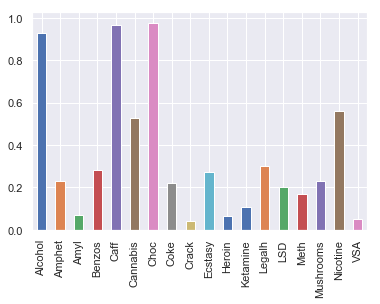

In [82]:
Targets_Binary_Year.mean().plot(kind='bar')

In [83]:
#Random Forest Classifier with Feature Selection and CV and Max Depth = 5 for drug use in last year
for drug in list(Targets_Binary_Year):
    data_np=np.asarray(data_dummies)
    target_np=np.asarray(Targets_Binary_Year[drug])
    header=[]
    #Feature Selection
    '''Three steps:
       1) Run Feature Selection
       2) Get lists of selected and non-selected features
       3) Filter columns from original dataset
       '''

    print('--FEATURE SELECTION ON--', '\n')
    print(Targets_Binary_Year[drug].name)

    ##1) Run Feature Selection #######
    #Wrapper Select via model
    if fs_type==2:
        clf = RandomForestClassifier(n_estimators = 100, max_depth = 5, min_samples_split = 3, criterion = "entropy",
                                 random_state = rand_st)            
        sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                   

        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()


    ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(i+feat_start)
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Wrapper Select:', data_dummies.columns.values[temp])
    print('Features (total/selected):', len(data_np[0]), len(temp))


    ##3) Filter selected columns from original dataset #########
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index  

####Cross-Val Classifiers####

    #Setup Crossval classifier scorers
    scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}                                                                                                                

    #SciKit Random Forest - Cross Val
    start_ts=time.time()

    scores = cross_validate(clf, data_np, y = target_np, scoring = scorers, cv = 5)


    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
    scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
    print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
    print("CV Runtime:", time.time()-start_ts)
        

--FEATURE SELECTION ON-- 

Alcohol
Wrapper Select: ['Age' 'Education' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore'
 'Impulsive' 'SS']
Features (total/selected): 22 9
Random Forest Acc: 0.93 (+/- 0.00)
Random Forest AUC: 0.59 (+/- 0.13)
CV Runtime: 0.5752403736114502
--FEATURE SELECTION ON-- 

Amphet
Wrapper Select: ['Age' 'Education' 'Oscore' 'Cscore' 'Impulsive' 'SS' 'Country_UK'
 'Country_USA']
Features (total/selected): 22 8
Random Forest Acc: 0.77 (+/- 0.06)
Random Forest AUC: 0.83 (+/- 0.13)
CV Runtime: 0.5153806209564209
--FEATURE SELECTION ON-- 

Amyl
Wrapper Select: ['Age' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore' 'Impulsive' 'SS'
 'Gender_Male']
Features (total/selected): 22 9
Random Forest Acc: 0.93 (+/- 0.00)
Random Forest AUC: 0.71 (+/- 0.16)
CV Runtime: 0.571974515914917
--FEATURE SELECTION ON-- 

Benzos
Wrapper Select: ['Age' 'Education' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore'
 'Impulsive' 'SS' 'Country_UK' 'Country_USA']
Features (total/selected): 22 11
Random Fo

In [84]:
Targets_Binary_Year['CokeCrack'] = 0

In [85]:
Targets_Binary_Year['CokeCrack'] = Targets_Binary_Year['Coke'] + Targets_Binary_Year['Crack']
Targets_Binary_Year['CokeCrack'] = Targets_Binary_Year['CokeCrack'].replace(2,1)

In [86]:
#Random Forest Classifier with Feature Selection and CV and Max Depth = 5 for Coke or Crack use in last year

data_np=np.asarray(data_dummies)
target_np=np.asarray(Targets_Binary_Year['CokeCrack'])
header=[]
#Feature Selection
'''Three steps:
   1) Run Feature Selection
   2) Get lists of selected and non-selected features
   3) Filter columns from original dataset
   '''

print('--FEATURE SELECTION ON--', '\n')
print(Targets_Binary_Year['CokeCrack'].name)

##1) Run Feature Selection #######
#Wrapper Select via model
if fs_type==2:
    clf = RandomForestClassifier(n_estimators = 100, max_depth = 5, min_samples_split = 3, criterion = "entropy",
                             random_state = rand_st)            
    sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                   

    fit_mod=sel.fit(data_np, target_np)    
    sel_idx=fit_mod.get_support()


##2) Get lists of selected and non-selected features (names and indexes) #######
temp=[]
temp_idx=[]
temp_del=[]
for i in range(len(data_np[0])):
    if sel_idx[i]==1:                                                           #Selected Features get added to temp header
        temp.append(i+feat_start)
        temp_idx.append(i)
    else:                                                                       #Indexes of non-selected features get added to delete array
        temp_del.append(i)
print('Wrapper Select:', data_dummies.columns.values[temp])
print('Features (total/selected):', len(data_np[0]), len(temp))


##3) Filter selected columns from original dataset #########
header = header[0:feat_start]
for field in temp:
    header.append(field)
data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index  

####Cross-Val Classifiers####

#Setup Crossval classifier scorers
scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}                                                                                                                

#SciKit Random Forest - Cross Val
start_ts=time.time()

scores = cross_validate(clf, data_np, y = target_np, scoring = scorers, cv = 5)


scores_Acc = scores['test_Accuracy']                                                                                                                                    
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
print("CV Runtime:", time.time()-start_ts)


--FEATURE SELECTION ON-- 

CokeCrack
Wrapper Select: ['Age' 'Nscore' 'Escore' 'Oscore' 'Ascore' 'Cscore' 'Impulsive' 'SS'
 'Country_UK']
Features (total/selected): 22 9
Random Forest Acc: 0.78 (+/- 0.01)
Random Forest AUC: 0.78 (+/- 0.13)
CV Runtime: 0.6081995964050293
